In [12]:
import pandas as pd
import requests
import urllib.parse
import geopy.distance
import numpy as np

In [2]:

df1 = pd.read_csv('stations.csv')
# df1.head(3)

df1=df1[['#station']]


In [3]:
finalDic={}

for index, row in df1.iterrows():
   currStation=row['#station']
   if currStation not in finalDic.keys():
       finalDic[currStation]=1
   else:
        finalDic[currStation]+=1

In [4]:
df2 = pd.read_csv('stations2.csv')
df2.head(3)

,#line,#station_B,accSum
0,Main Line,Fort,30
1,Main Line,Maradana,23
2,Main Line,Kelaniya,4


In [5]:
for index, row in df2.iterrows():
   currStation=row['#station_B']
   if currStation not in finalDic.keys():
       finalDic[currStation]=1
   else:
        finalDic[currStation]+=row['accSum']

In [6]:
newDic={'station':[],'countAccidents':[]}

for key,value in finalDic.items():
       newDic['station'].append(key)
       newDic['countAccidents'].append(value)
df3=pd.DataFrame.from_dict(newDic)
df3.head(3)

,station,countAccidents
0,Fort,32
1,Maradana,24
2,Dematagoda,1


In [ ]:
df3['lat']=None
df3['lon']=None

for i in range(len(df3)):
 
  address = df3.iat[i,0]+' railway station, sri lanka'
  
  try:
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
    response = requests.get(url).json()
    cod1=response[0]["lat"]
    cod2=response[0]["lon"]

    # result=gmaps_key.geocode(address)
    # cod1=result[0]['geometry']['location']['lat']
    # cod2=result[0]['geometry']['location']['lat']
    # print(cod1,cod2)
    df3.iat[i,df3.columns.get_loc("lat")]=cod1
    df3.iat[i,df3.columns.get_loc("lon")]=cod2
  except:
    pass
 
  if i%15==0:
    
     print(df3.loc[[i]])
      
# print(df3)
   

In [ ]:
df3.info()

In [ ]:
dfTrain = pd.read_csv('trainPaths.csv')
dfTrain.dtypes

In [ ]:
df4=df3.copy()
df4=df4.dropna()
df4.reset_index(drop=True, inplace=True)
df4.info()

In [ ]:
df4.head()

In [ ]:
df4['lat'] = df4['lat'].astype(float)
df4['lon'] = df4['lon'].astype(float)

df4.dtypes

In [ ]:
rowCount=0
for i in range(len(df4)):
  count=0
  val = df4.iat[i,1]
  latDis=df4.iat[i,2]
  lonDis=df4.iat[i,3]
  
  for j in range(len(dfTrain)):   
    lat,lon = dfTrain.iat[j,0],dfTrain.iat[j,1]
    dist=geopy.distance.geodesic((lat,lon), (latDis,lonDis)).m
    if dist<700 and (lat not in df4['lat'].values or lat not in df4['lon'].values ):
              newRow={'station':df4.iat[i,0] , 'countAccidents': val, 'lat': lat,'lon':lon}
              df4 = df4.append(newRow, ignore_index=True)
              if rowCount%20==0:
                print("row Added",rowCount)
              rowCount+=1
              count+=1
    if count==(20 if val>1 else 5):
        print("breaked")
        break
  
            
     
      

In [73]:
df4.to_csv('trainLocationFinalData.csv', index=False)

In [4]:
df4=pd.read_csv('trainLocationFinalData.csv')

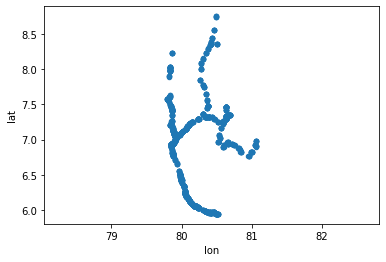

In [5]:
import matplotlib.pyplot as plt

ax =df4.plot(kind='scatter', x='lon', y='lat')
ax.axis('equal')

# plt.savefig('trainValues.svg', format='svg', bbox_inches='tight')
# plt.savefig('sine_wave.png', dpi=300)
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

X = scaler1.fit_transform(df4[['lat','lon']])
y=scaler2.fit_transform(df4[['countAccidents']])


In [7]:
import pickle
scalerfile1 = 'scalerLocation.sav'
scalerfile2 = 'scalerLocationYData.sav'
pickle.dump(scaler1, open(scalerfile1, 'wb'))
pickle.dump(scaler2, open(scalerfile2, 'wb'))

In [8]:
# Extracting the independent variables and dependent variable

print(X.shape,y.shape)

(1634, 2) (1634, 1)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# Creating the polynomial features of degree 2
poly = PolynomialFeatures(degree=80)
X_poly = poly.fit_transform(X)

# Creating the regression model
regressor = LinearRegression()

# Training the model on the polynomial features
regressor.fit(X_poly, y)

# Predicting the output
y_pred = regressor.predict(X_poly)

# Printing the coefficients and intercept
print("Coefficients: ", regressor.coef_)
print("Intercept: ", regressor.intercept_)


Coefficients:  [[-3.55133215e+12 -3.77160616e+07 -5.83396966e+07 ... -7.03289679e+10
   3.72277391e+12  3.06716405e+12]]
Intercept:  [3.5513343e+12]


In [10]:
# save model
import joblib

joblib.dump(regressor, 'locationDetecter')
joblib.dump(poly, 'locationDetecterPolynomial')

# load and predict
poilynomia_features_model = joblib.load('locationDetecterPolynomial')
themodel = joblib.load('locationDetecter')

X_val_prep = poilynomia_features_model.transform(X)
predictions = themodel.predict(X_val_prep)




In [ ]:
original=scaler2.inverse_transform(y_pred)
nonScaled=scaler2.inverse_transform(y)

myArr= np.concatenate((original, nonScaled), axis=1)
print(myArr[:50])

In [ ]:
import pickle
scalerfile = 'scalerLocationYData.sav'
scalerNew = pickle.load(open(scalerfile, 'rb'))

original=scalerNew.inverse_transform(predictions)
nonScaled=scalerNew.inverse_transform(y)

myArr= np.concatenate((original, nonScaled), axis=1)
print(myArr[:50])

In [15]:
from sklearn.metrics import r2_score
# calculate R-squared of the model
r2 = r2_score(y, predictions)
print("R-squared score: ", r2)

R-squared score:  0.7725284152628901
